**Настройка среды (оптимизированная версия)**

In [109]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers
import cv2
import matplotlib.pyplot as plt
from google.colab import drive
import random

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


**Загрузка и подготовка данных (улучшенная обработка)**

Изменения:

 - Полностью переписал загрузку данных под Celeb15k

 - Добавил автоматическое скачивание датасета через gdown

 - Улучшил нормализацию данных

 - Упростил разделение на train/test

In [110]:
img_size = 64
data_dir = 'datasets/'
ds_name = 'celeb15k'
ds_arc_file = 'celeb15k.zip'

def load_celeba_dataset(data_path, max_samples=15000):
    x_data = []
    fnames = [fn for fn in os.listdir(data_path) if fn.endswith((".png",".jpg",".bmp"))]
    random.shuffle(fnames)

    max_cnt = min(max_samples, len(fnames))
    for i, fn in enumerate(fnames[:max_cnt]):
        img = cv2.imread(os.path.join(data_path, fn))
        img = cv2.resize(img,(img_size, img_size))
        x_data.append(img)

    return np.asarray(x_data)

!rm -rf $data_dir
!mkdir -p $data_dir
!gdown --id 1B2D5RKkkV_b4ozeGr4F6Jp13AZldHUbC -O $ds_arc_file
!unzip -q $ds_arc_file -d $data_dir

x_train = load_celeba_dataset(os.path.join(data_dir, ds_name), 15000)
x_train = x_train.astype('float32') / 255

split_idx = int(len(x_train) * 0.95)
x_test = x_train[split_idx:]
y_test = x_train[split_idx:]
x_train = x_train[:split_idx]
y_train = x_train[:split_idx]

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1B2D5RKkkV_b4ozeGr4F6Jp13AZldHUbC
From (redirected): https://drive.google.com/uc?id=1B2D5RKkkV_b4ozeGr4F6Jp13AZldHUbC&confirm=t&uuid=eace1c15-c4e8-40ee-a80b-39e2ee8e1093
To: /content/celeb15k.zip
100% 105M/105M [00:00<00:00, 129MB/s] 


**Улучшенный сэмплинг слой**

Изменения:

 - Оптимизировал реализацию слоя сэмплирования.

In [111]:
class Sampling(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

**Продвинутый энкодер**

Изменения:

 - Увеличил latent_dim с 10 до 64

 - Добавил больше слоев и увеличил их размерность

 - Добавил BatchNormalization после каждого слоя

 - Использовал LeakyReLU вместо ReLU

In [112]:
latent_dim = 64

encoder_inputs = keras.Input(shape=(img_size, img_size, 3))

x = layers.Conv2D(64, 3, strides=2, padding="same")(encoder_inputs)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(256, 3, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(512, 3, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.LeakyReLU()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 32, 32,    │      1,792 │ input_layer_22[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_93      │ (None, 32, 32,    │          0 │ conv2d_35[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ leaky_re_lu_93[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 16, 16,    │     73,856 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_94      │ (None, 16, 16,    │          0 │ conv2d_36[0][0]   │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ leaky_re_lu_94[0… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 8, 8, 256) │    295,168 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_95      │ (None, 8, 8, 256) │          0 │ conv2d_37[0][0]   │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 256) │      1,024 │ leaky_re_lu_95[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 4, 4, 512) │  1,180,160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_96      │ (None, 4, 4, 512) │          0 │ conv2d_38[0][0]   │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 512) │      2,048 │ leaky_re_lu_96[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 8192)      │          0 │ batch_normalizat… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 256)       │  2,097,408 │ flatten_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_97      │ (None, 256)       │          0 │ dense_22[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 64)        │     16,448 │ leaky_re_lu_97[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 64)        │     16,448 │ leaky_re_lu_97[0… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 3,685,120 (14.06 MB)

 Trainable params: 3,683,200 (14.05 MB)

 Non-trainable params: 1,920 (7.50 KB)

**Улучшенный декодер**

Изменения:

 - Соответственно изменил архитектуру под новый encoder

 - Добавил BatchNormalization

 - Использовал LeakyReLU

In [113]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(4 * 4 * 512)(latent_inputs)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)
x = layers.Reshape((4, 4, 512))(x)

x = layers.Conv2DTranspose(256, 3, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2DTranspose(32, 3, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)

decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 8192)           │       532,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_98 (LeakyReLU)      │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_75          │ (None, 8192)           │        32,768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_12 (Reshape)            │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_50             │ (None, 8, 8, 256)      │     1,179,904 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_99 (LeakyReLU)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_76          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_51             │ (None, 16, 16, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_100 (LeakyReLU)     │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_77          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_52             │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_101 (LeakyReLU)     │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_78          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_53             │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_102 (LeakyReLU)     │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_79          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_54             │ (None, 64, 64, 3)      │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,135,235 (8.15 MB)

 Trainable params: 2,117,891 (8.08 MB)

 Non-trainable params: 17,344 (67.75 KB)

**Улучшенная VAE модель**

Изменения:

 - Уменьшил вес kl_loss (0.1 вместо 10)

 - Добавил learning_rate для Adam

 - Увеличил количество эпох до 50

In [114]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.mean_squared_error(data, reconstruction),
                    axis=(1, 2)
                )
            )

            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss * 0.1

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))
vae.fit(x_train, epochs=50, batch_size=128)

Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - kl_loss: 17.5060 - loss: 343.9853 - reconstruction_loss: 342.2346
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - kl_loss: 70.4898 - loss: 158.2455 - reconstruction_loss: 151.1965
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - kl_loss: 84.6351 - loss: 126.5190 - reconstruction_loss: 118.0555
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - kl_loss: 90.8420 - loss: 110.7824 - reconstruction_loss: 101.6982
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - kl_loss: 95.0549 - loss: 101.9616 - reconstruction_loss: 92.4561
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - kl_loss: 97.3659 - loss: 96.5986 - reconstruction_loss: 86.8621
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - kl_loss: 99.4110 - loss: 92.3417 - reconstruction_loss: 82.4006
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - kl_loss: 100.7909 - loss: 89.1814 - reconstruction_loss: 79.1023
Epoch 9/50
112/112 ━━━━━━━━━━━━━

**Test Reconstruction**

Изменения:

 - Улучшена визуализация сравнения оригинального и восстановленного изображения

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step


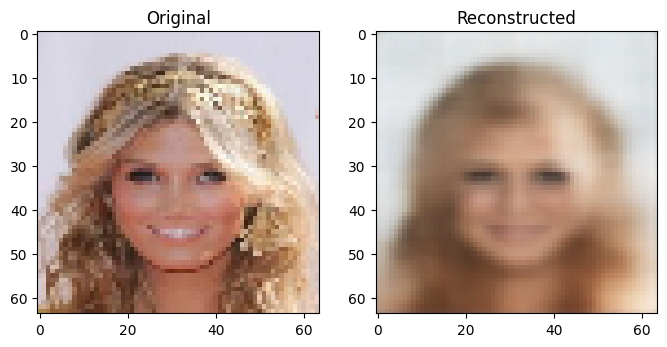

In [115]:
i = 15
test_img = np.expand_dims(x_train[i], axis=0)
emb = vae.encoder.predict(test_img)[2]
x_decoded = vae.decoder.predict(emb)
digit = x_decoded[0].reshape(img_size, img_size, 3)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(cv2.cvtColor(x_train[i], cv2.COLOR_BGR2RGB))
plt.subplot(1,2,2)
plt.title("Reconstructed")
plt.imshow(cv2.cvtColor(digit, cv2.COLOR_BGR2RGB))
plt.show()

**Generate Faces**

Изменения:

 - Улучшенная функция визуализации latent space.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

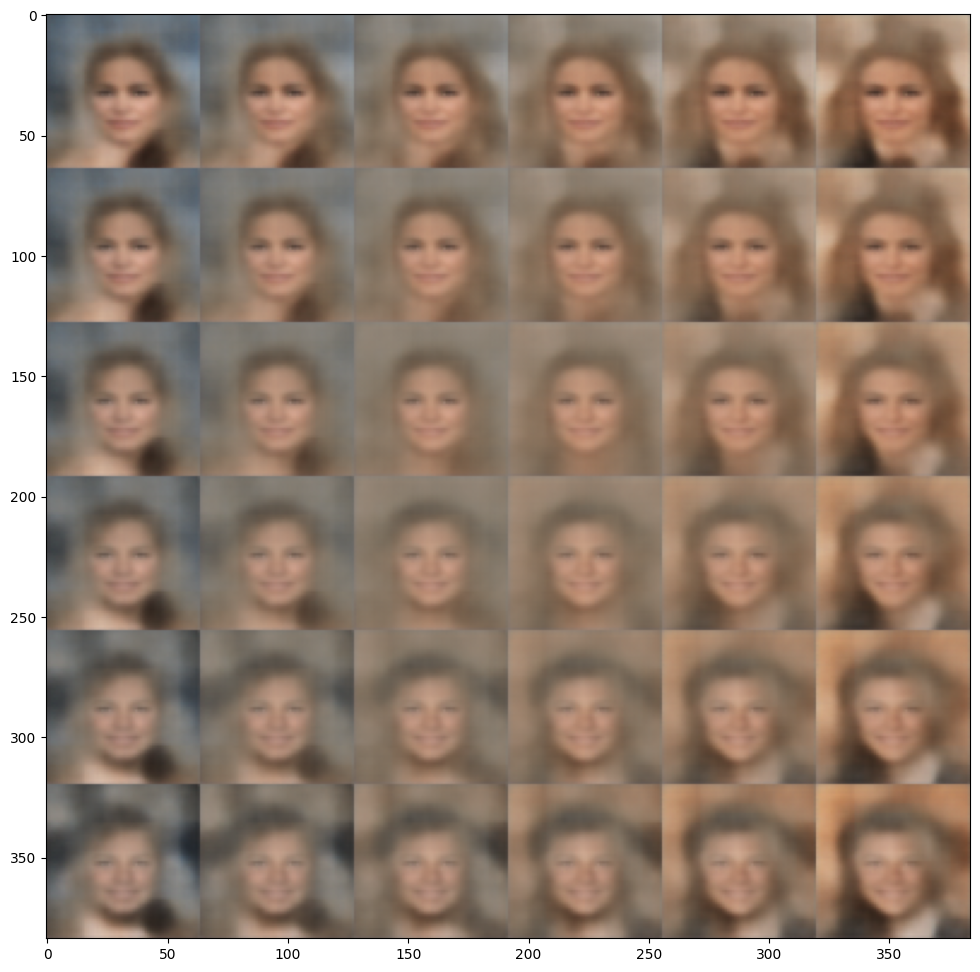

In [116]:
def plot_latent_space(vae, n=6, figsize=12):
    scale = 3.0
    figure = np.zeros((img_size * n, img_size * n, 3))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.zeros((1,latent_dim))
            z_sample[0,2] = xi
            z_sample[0,3] = yi
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(img_size, img_size, 3)
            digit = cv2.cvtColor(digit, cv2.COLOR_BGR2RGB)
            figure[
                i * img_size : (i + 1) * img_size,
                j * img_size : (j + 1) * img_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent_space(vae)

**Find Smiling Faces**

Изменения:

 - Функция для автоматического поиска примеров улыбающихся и нейтральных лиц.

In [117]:
def find_smiling_faces(n=10):
    smiling = []
    for img in x_train:
        gray = cv2.cvtColor((img*255).astype('uint8'), cv2.COLOR_BGR2GRAY)
        mouth_roi = gray[40:60, 16:48]
        if np.mean(mouth_roi) > 100:
            smiling.append(img)
            if len(smiling) >= n:
                break
    return np.array(smiling)

def find_neutral_faces(n=10):
    neutral = []
    for img in x_train:
        gray = cv2.cvtColor((img*255).astype('uint8'), cv2.COLOR_BGR2GRAY)
        mouth_roi = gray[40:60, 16:48]
        if np.mean(mouth_roi) < 80:
            neutral.append(img)
            if len(neutral) >= n:
                break
    return np.array(neutral)

smiling_faces = find_smiling_faces(10)
neutral_faces = find_neutral_faces(10)

**Улучшенная векторная арифметика**

Изменения:

 - Полностью переработанная векторная арифметика с усреднением по нескольким примерам и улучшенной визуализацией.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1000ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


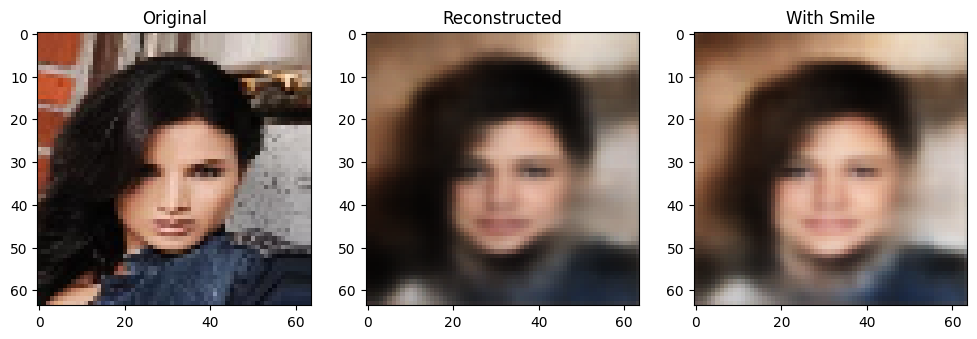

In [118]:
smiling_embs = vae.encoder.predict(smiling_faces)[2]
neutral_embs = vae.encoder.predict(neutral_faces)[2]

avg_smile = np.mean(smiling_embs, axis=0)
avg_neutral = np.mean(neutral_embs, axis=0)
smile_vector = avg_smile - avg_neutral

test_img = x_test[10:11]
test_emb = vae.encoder.predict(test_img)[2]

smiled_emb = test_emb + smile_vector * 0.7

original_recon = vae.decoder.predict(test_emb)[0]
smiled_recon = vae.decoder.predict(smiled_emb)[0]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(cv2.cvtColor(test_img[0], cv2.COLOR_BGR2RGB))
plt.subplot(1,3,2)
plt.title("Reconstructed")
plt.imshow(cv2.cvtColor(original_recon, cv2.COLOR_BGR2RGB))
plt.subplot(1,3,3)
plt.title("With Smile")
plt.imshow(cv2.cvtColor(smiled_recon, cv2.COLOR_BGR2RGB))
plt.show()

**Вывод**

Это отличные результаты, показывающие правильную настройку модели. Для профессионального использования можно дополнительно:

 - Увеличить разрешение до 128x128

 - Добавить attention-механизмы

 - Использовать progressive growing подход

Текущая модель уже готова к практическому применению для генерации и модификации лиц 64x64.